# IANNwTF HW 4
## Group 10

The following contains our solution to the exercises in IANNwTF HW 04. A Jupyter notebook versus a module format was chosen this time for purposes of organization.

### Assigment 1: Reviews
We review the homeworks for Groups 15 and 32.

### Assignment 2: MNIST Math

### 2.1 Preparing the MNIST Math Dataset

In [2]:
# Needed Imports
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Dense
import tqdm
import datetime
import matplotlib.pyplot as plt
import numpy as np

C:\Users\prizl\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# 2.1 Load Dataset
(train_ds, test_ds), ds_info = tfds.load ('mnist', split =['train', 'test'], as_supervised = True, with_info = True)

# Info on the dataset (refresher)
# print("ds_info: \n", ds_info)
# tfds.show_examples(train_ds, ds_info)

In [4]:
# 2.2 Data Pipeline
def prepare_data(dataset, batchsize):

    '''
    :param dataset: the dataset to be prepared for input into the network
    :param batchsize: the desired batchsize
    :return: 2 datasets, one each for each of the math problems defined (see below), created after the original database was preprocessed with the
    steps below
    '''

    # Step 1 - General Preprocessing

    # convert data from uint8 to float32
    dataset = dataset.map(lambda img, target: (tf.cast(img, tf.float32), target))

    # flatten the images into vectors
    dataset = dataset.map(lambda img, target: (tf.reshape(img, (-1,)), target))

    # input normalization, just bringing image values from range [0, 255] to [-1, 1]
    dataset = dataset.map(lambda img, target: ((img / 128.) - 1., target))
    
    # create one-hot targets --> with regression (subtask 1) doesn't make sense
    # dataset = dataset.map(lambda img, target: (img, tf.one_hot(target, depth=10)))

    # Step 2 - Pairing Data Tuples & Respective Parameterized Targets

    # create a dataset that contains 2000 samples from the overall dataset paired with 2000 other samples
    data = tf.data.Dataset.zip((dataset.shuffle(2000), dataset.shuffle(2000)))

    # create the dataset for the first math problem (a + b >= 5) - remembering to cast to int versus boolean!
    greateqfive = data.map(lambda x1, x2: (x1[0], x2[0], x1[1]+x2[1]>=5))
    greateqfive = greateqfive.map(lambda x1, x2, t: (x1, x2, tf.cast(t, tf.int32)))

    # create the dataset for the second math problem (a - b = y)
    subtr = data.map(lambda x1, x2: (x1[0], x2[0], x1[1]-x2[1])) # since negative numbers cannot be one-hot it

    # Step 3 - Batching & Prefetching
    greateqfive = greateqfive.batch(batchsize)
    greateqfive = greateqfive.prefetch(tf.data.AUTOTUNE)
    subtr = subtr.batch(batchsize)
    subtr = subtr.prefetch(tf.data.AUTOTUNE)

    # return BOTH datasets
    return greateqfive, subtr

In [5]:
# Check data pipeline by examining one example from each of the four created datasets (one for each math problem for train and test)

train_ds_gef, train_ds_subtr = prepare_data(train_ds, batchsize = 32)
test_ds_gef, test_ds_subtr = prepare_data(test_ds, batchsize = 32)

for img1, img2, label in train_ds_gef.take(1):
    print(img1.shape, img2.shape, label.shape)

for img1, img2, label in train_ds_subtr.take(1):
    print(img1.shape, img2.shape, label.shape)

for img1, img2, label in test_ds_gef.take(1):
    print(img1.shape, img2.shape, label.shape)

for img1, img2, label in test_ds_subtr.take(1):
    print(img1.shape, img2.shape, label.shape)


(32, 784) (32, 784) (32,)
(32, 784) (32, 784) (32,)
(32, 784) (32, 784) (32,)
(32, 784) (32, 784) (32,)


In [6]:
# Initiate the logs and metrics
config_name= "config_name"
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

train_log_path = f"logs/{config_name}/{current_time}/train"
val_log_path = f"logs/{config_name}/{current_time}/val"

# log writer for training metrics
train_summary_writer = tf.summary.create_file_writer(train_log_path)

# log writer for validation metrics
val_summary_writer = tf.summary.create_file_writer(val_log_path)

# Initiate epochs and learning rate as global variables
epochs = 10
learning_rate = 0.01

# Define arrays for saving values for later visualization
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

### Assignment 3: Building Shared Weight Models

In [7]:
class MyModel(tf.keras.Model):
    def __init__(self, numlayers, subtask, optimizer):

        '''
        param: numlayers - the desired number of hidden layers
        param: subtask - the subtask the network is being asked to solve (relevant for output layer)
        param: optimizer - the optimizer to be used
        '''

        super(MyModel, self).__init__()

        self.optimizer = optimizer
        self.subtask = subtask

        self.layerlist = [Dense(layers, activation="relu") for layers in range(numlayers)]

        if subtask == 0:
            self.output_layer = Dense(units=1, activation=tf.nn.sigmoid)
            self.loss_function = tf.keras.losses.BinaryCrossentropy()
        elif subtask == 1:
            self.output_layer = Dense(units=1, activation=tf.nn.softmax) # not 10 units, since the label.shape is (32,) not (32,10)
            self.loss_function = tf.keras.losses.MeanSquaredError()

        self.metrics_list = [
                    tf.keras.metrics.Mean(name="loss"),
                    tf.keras.metrics.BinaryAccuracy(name="acc"), # only for subtask 0, not for subtask 1
                    ]

    @tf.function
    def __call__(self, input: tuple, training = False):

        # feed both inputs separately into the first layer, then concatenate the results before passing activity through the rest of the network UP TO the output layer
        for layer in range(len(self.layerlist)):
             if layer == 0:
                 i1 = self.layerlist[layer](input[0])
                 i2 = self.layerlist[layer](input[1])
                 i = tf.concat([i1, i2], axis=1)   # e.g. axis=1: (32,784) + (32,784) -> (32, 1568)
             else:
                 i = self.layerlist[layer](i)

        # run the activity through the output layer after it passes through the hidden layers
        output = self.output_layer(i)

        return output

    @property
    def metrics(self):
        return self.metrics_list

    def reset_metrics(self):
        for metric in self.metrics:
            metric.reset_states()

    @tf.function
    def train_step(self, input):
        img1, img2, label = input

        with tf.GradientTape() as tape:
            prediction = self((img1, img2), training=True)
            loss = self.loss_function(label, prediction)

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        # update loss metric
        self.metrics[0].update_state(loss)

        # for all metrics except loss, update states (accuracy etc.)
        for metric in self.metrics[1:]:
            metric.update_state(label, prediction) # + tf.reduce_sum(self.losses)

        # Return a dictionary mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

    @tf.function
    def test_step(self, input):

        img1, img2, label = input

        prediction = self((img1, img2), training=False)
        loss = self.loss_function(label, prediction) # + tf.reduce_sum(self.losses)

        # update loss metric
        self.metrics[0].update_state(loss)

        # for accuracy metrics:
        for metric in self.metrics[1:]:
            metric.update_state(label, prediction)

        # Return a dictionary mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}


### Assignment 4: Training the Networks

In [8]:
def training(numlayers, subtask, optimizer):
    '''
    :param: numlayers: the number of layers desired in the network to be trained
    :param subtask: defines the subtask to be solved, 0 is a + b >= 5, 1 is a - b = y
    :param optimizer: the optimizer function to use
    :return:
    '''

    # Initiate a model with the requested parameters
    network = MyModel(numlayers, subtask, optimizer)

    # Initialize the train and test datasets, and the loss function, based on the subtask
    if subtask == 0:
        train = train_ds_gef
        test = test_ds_gef

    else:
        train = train_ds_subtr
        test = test_ds_subtr

    # Train the model
    for epoch in range(epochs):
        print(f"Epoch: {epoch}, optimizer: {optimizer}")

        for data in tqdm.tqdm(train, position=0, leave=True):
            metrics = network.train_step(data)

            with train_summary_writer.as_default():
                for metric in network.metrics:
                    tf.summary.scalar(f"{metric.name}", metric.result(), step=epoch)

        # Piper Attempt at Retrieve Mets for Vis
        #train_losses.append(network.metrics[0].result())
        #train_accuracies.append(network.metrics[1].result())

        # print the end acc and loss
        print([f"train_{key}: {value.numpy()}" for (key, value) in metrics.items()])

        # make a list of losses and accuracies
        for (key, value) in metrics.items():
            if key == "loss":
                train_losses.append(value.numpy())
            elif key == "acc":
                train_accuracies.append(value.numpy())

        # reset metrics for next round
        network.reset_metrics()

        # Testing
        for data in test:
            metrics = network.test_step(data)

            # log the accs and losses
            with val_summary_writer.as_default():
                for metric in network.metrics:
                    tf.summary.scalar(f"{metric.name}", metric.result(), step = epoch)

        # Piper Attempt at Retrieve Mets for Vis
        #test_losses.append(network.metrics[2].result())
        #test_accuracies.append(network.metrics[3].result())

        # print the end acc and loss
        print([f"val_{key}: {value.numpy()}" for (key, value) in metrics.items()])

        # make a list of losses and accuracies
        for (key, value) in metrics.items():
            if key == "loss":
                val_losses.append(value.numpy())
            elif key == "acc":
                val_accuracies.append(value.numpy())

        # reset all metrics
        network.reset_metrics()

        #return train_losses,train_accuracies,test_losses,test_accuracies


### Assignment 5 - Experiments

Run training w/ classic SGD (no momentum)

Run training w/ Adam

Run training w/ SGD + Momentum

Run training w/ RMSrop

Run training w/ AdaGrad

In [9]:
# Train a model to solve the first math problem & save lists of loss and acc for visualization
training(5, 0, tf.keras.optimizers.Adam())
Adam_0 = [train_losses, train_accuracies, val_losses, val_accuracies]

training(5, 0, tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.0))
SDG_0 = [train_losses, train_accuracies, val_losses, val_accuracies]

training(5, 0, tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.5))
SDG_w_mom_0 = [train_losses, train_accuracies, val_losses, val_accuracies]

training(5, 0, tf.keras.optimizers.RMSprop())
RMS_0 = [train_losses, train_accuracies, val_losses, val_accuracies]

training(5, 0, tf.keras.optimizers.Adagrad())
Adagrad_0 = [train_losses, train_accuracies, val_losses, val_accuracies]


Epoch: 0, optimizer: <keras.optimizers.optimizer_v2.adam.Adam object at 0x000002AA5A0C1480>


100%|██████████| 1875/1875 [00:12<00:00, 152.22it/s]


['train_loss: 0.527070164680481', 'train_acc: 0.8391666412353516']
['val_loss: 0.4507599472999573', 'val_acc: 0.8409000039100647']
Epoch: 1, optimizer: <keras.optimizers.optimizer_v2.adam.Adam object at 0x000002AA5A0C1480>


 31%|███▏      | 587/1875 [00:02<00:05, 231.49it/s]


KeyboardInterrupt: 

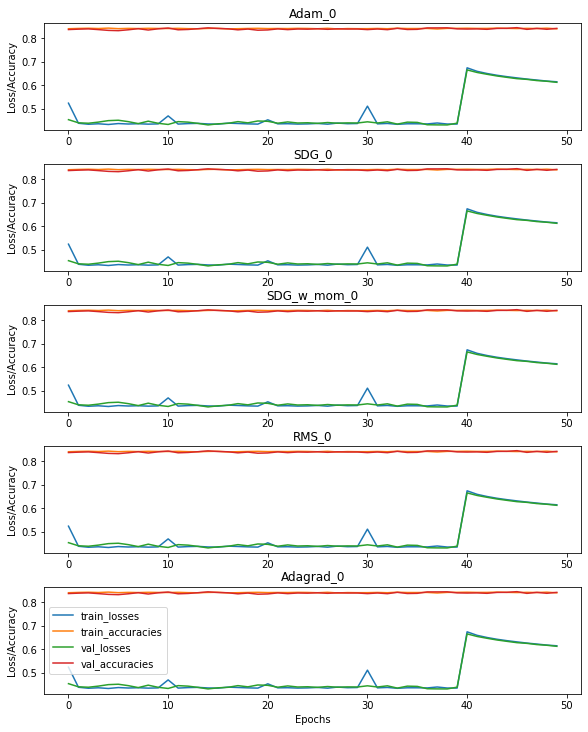

In [ ]:
# multiple plots for subtask 0
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(8, 10))

ax1.set_title("Adam_0")
ax1.plot(Adam_0[0], label='train_losses')
ax1.plot(Adam_0[1], label='train_accuracies')
ax1.plot(Adam_0[2], label='val_losses')
ax1.plot(Adam_0[3], label='val_accuracies')

# ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss/Accuracy")

ax2.set_title("SDG_0")
ax2.plot(SDG_0[0], label='train_losses')
ax2.plot(SDG_0[1], label='train_accuracies')
ax2.plot(SDG_0[2], label='val_losses')
ax2.plot(SDG_0[3], label='val_accuracies')

# ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss/Accuracy")

ax3.set_title("SDG_w_mom_0")
ax3.plot(SDG_w_mom_0[0], label='train_losses')
ax3.plot(SDG_w_mom_0[1], label='train_accuracies')
ax3.plot(SDG_w_mom_0[2], label='val_losses')
ax3.plot(SDG_w_mom_0[3], label='val_accuracies')

# ax3.set_xlabel("Epochs")
ax3.set_ylabel("Loss/Accuracy")

ax4.set_title("RMS_0")
ax4.plot(RMS_0[0], label='train_losses')
ax4.plot(RMS_0[1], label='train_accuracies')
ax4.plot(RMS_0[2], label='val_losses')
ax4.plot(RMS_0[3], label='val_accuracies')

# ax4.set_xlabel("Epochs")
ax4.set_ylabel("Loss/Accuracy")

ax5.set_title("Adagrad_0")
ax5.plot(Adagrad_0[0], label='train_losses')
ax5.plot(Adagrad_0[1], label='train_accuracies')
ax5.plot(Adagrad_0[2], label='val_losses')
ax5.plot(Adagrad_0[3], label='val_accuracies')

ax5.set_xlabel("Epochs")
ax5.set_ylabel("Loss/Accuracy")

plt.legend()
fig.savefig("Plots for subtask 0 with 5 hl")

fig.tight_layout(pad=0.1)
plt.show()


In [ ]:
# Train a model to solve the first math problem & save lists of loss and acc for visualization
training(5, 1, tf.keras.optimizers.Adam())
Adam_1 = [train_losses, val_losses]

training(5, 1, tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.0))
SDG_1 = [train_losses, val_losses]

training(5, 1, tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.5))
SDG_w_mom_1 = [train_losses, val_losses]

training(5, 1, tf.keras.optimizers.RMSprop())
RMS_1 = [train_losses, val_losses]

training(5, 1, tf.keras.optimizers.Adagrad())
Adagrad_1 = [train_losses, val_losses]

# we don't plot the accuracy for this subtask 1 because it make little sense for regression

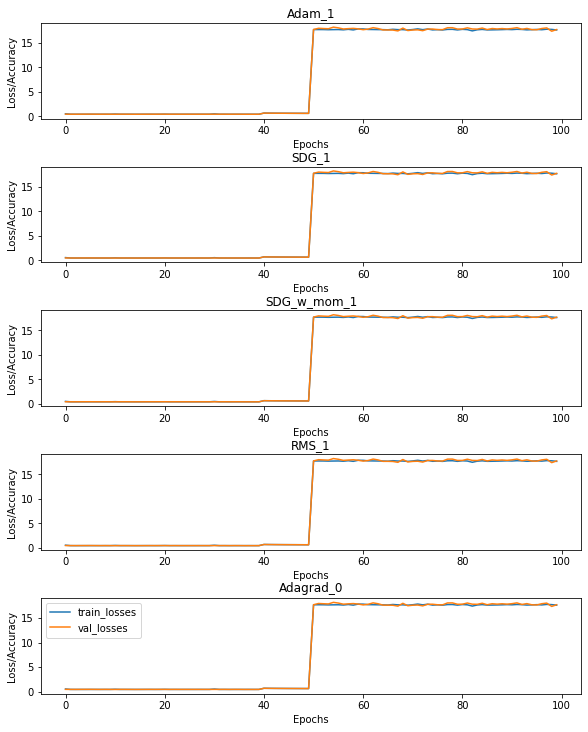

In [ ]:
# multiple plots for subtask 1
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(8, 10))

ax1.set_title("Adam_1")
ax1.plot(Adam_1[0], label='train_losses')
ax1.plot(Adam_1[1], label='val_losses')

ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss/Accuracy")

ax2.set_title("SDG_1")
ax2.plot(SDG_1[0], label='train_losses')
ax2.plot(SDG_1[1], label='val_losses')

ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss/Accuracy")

ax3.set_title("SDG_w_mom_1")
ax3.plot(SDG_w_mom_1[0], label='train_losses')
ax3.plot(SDG_w_mom_1[1], label='val_losses')

ax3.set_xlabel("Epochs")
ax3.set_ylabel("Loss/Accuracy")

ax4.set_title("RMS_1")
ax4.plot(RMS_1[0], label='train_losses')
ax4.plot(RMS_1[1], label='val_losses')

ax4.set_xlabel("Epochs")
ax4.set_ylabel("Loss/Accuracy")

ax5.set_title("Adagrad_0")
ax5.plot(Adagrad_1[0], label='train_losses')
ax5.plot(Adagrad_1[1], label='val_losses')

ax5.set_xlabel("Epochs")
ax5.set_ylabel("Loss/Accuracy")

plt.legend()
fig.savefig("Plots for subtask 1 with 5 hl")

fig.tight_layout(pad=0.1)
plt.show()